## Exploratory Data Analysis for BigMart sales data

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor, Pool, cv

In [2]:
#Importing datasets
train = pd.read_csv("//Users//anushreesv//Downloads//ABB_coding_test//train_v9rqX0R.csv")
test = pd.read_csv("//Users//anushreesv//Downloads//ABB_coding_test//test_AbJTz2l.csv")
print(f"Train -{train.shape}, Test -{test.shape}")

Train -(8523, 12), Test -(5681, 11)


In [3]:
## Concat the above datasets for preprocessing
sales_data=pd.concat([train,test],axis=0)
sales_data.shape

(14204, 12)

Check for duplicate rows in the data:

In [ ]:
len(sales_data[sales_data.duplicated()==True])
# No duplicate rows

0

In [4]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14204 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.4+ MB



 We can see from above that Item_Weight and Outlet_Size have missing values. We will handle them in the preprocessing step.

In [5]:
num_cols=sales_data.select_dtypes(include=['int64','float64']).columns
print(f"Numerical features: {num_cols}")
cat_cols=sales_data.select_dtypes(include=['object']).columns
print(f"Categorical features: {cat_cols}")

Numerical features: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')
Categorical features: Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


In [7]:
sales_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Item_Identifier,14204,1559,FDU15,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Weight,11765.0,NaN,NaN,NaN,12.792854,4.652502,4.555,8.71,12.6,16.75,21.35
Item_Fat_Content,14204,5,Low Fat,8485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Visibility,14204.0,NaN,NaN,NaN,0.065953,0.051459,0.0,0.027036,0.054021,0.094037,0.328391
Item_Type,14204,16,Fruits and Vegetables,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_MRP,14204.0,NaN,NaN,NaN,141.004977,62.086938,31.29,94.012,142.247,185.8556,266.8884
Outlet_Identifier,14204,10,OUT027,1559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Establishment_Year,14204.0,NaN,NaN,NaN,1997.830681,8.371664,1985.0,1987.0,1999.0,2004.0,2009.0
Outlet_Size,10188,3,Medium,4655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Location_Type,14204,3,Tier 3,5583,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Numerical features

We will explore numerical columns with some charts to see outliers

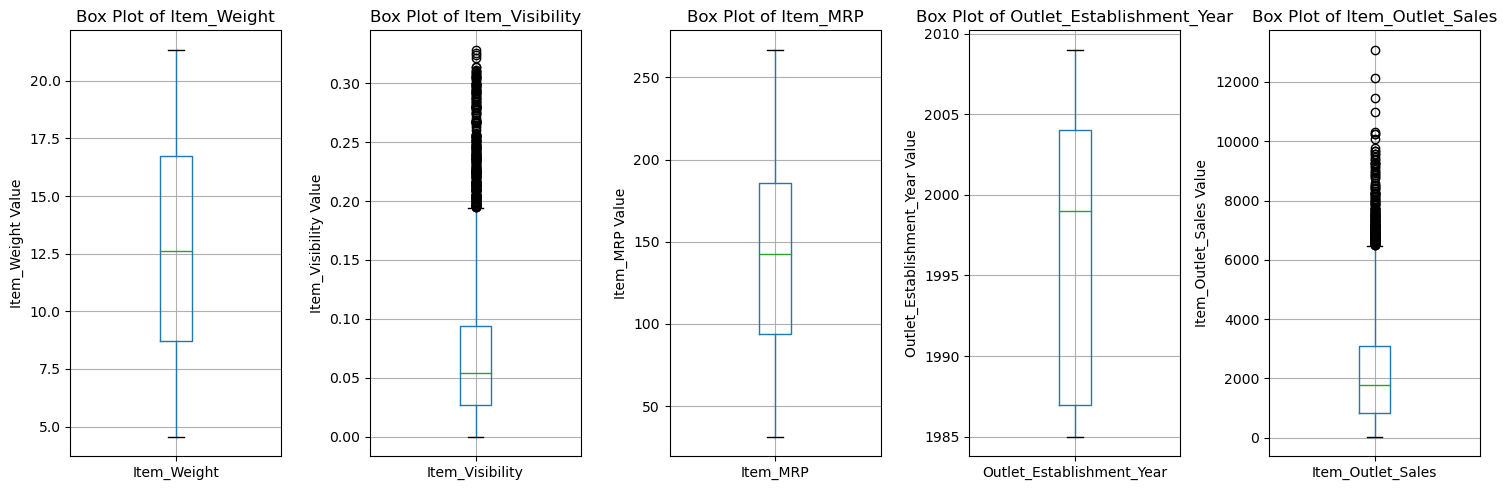

In [13]:

fig, axes = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(15, 5))

for i, col in enumerate(num_cols):
    sales_data.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_ylabel(f'{col} Value')

plt.tight_layout()

plt.show()

We see some outliers in Item_Visibility and Item_Outlet_Sales. We will try to fix them. 
Lets see some percentiles for these columns

In [23]:

def get_percentiles(column_name):
    percentiles = sales_data[column_name].quantile(percentile_list)
    print(percentiles)

In [24]:
percentile_list=[0,0.01,0.02,0.03,0.04,0.05,0.1,0.5, 0.75, 0.9, 0.95, 0.95,0.97,0.98,0.99,1]

In [26]:
get_percentiles('Item_Outlet_Sales')

0.00       33.290000
0.01       83.890800
0.02      115.476352
0.03      145.583828
0.04      169.699104
0.05      188.421400
0.10      343.552800
0.50     1794.331000
0.75     3101.296400
0.90     4570.051200
0.95     5522.811000
0.95     5522.811000
0.97     6094.307088
0.98     6623.831144
0.99     7366.011720
1.00    13086.964800
Name: Item_Outlet_Sales, dtype: float64


We see a big shift after 99th percentile indicating the outliers, similarly we can treat the values to the left of 1st percentile

In [27]:
get_percentiles('Item_Visibility')

0.00    0.000000
0.01    0.000000
0.02    0.000000
0.03    0.000000
0.04    0.000000
0.05    0.000000
0.10    0.011797
0.50    0.054021
0.75    0.094037
0.90    0.137645
0.95    0.163299
0.95    0.163299
0.97    0.176182
0.98    0.187841
0.99    0.230385
1.00    0.328391
Name: Item_Visibility, dtype: float64


We see that lower 5 percentiles are all zeros. Lets find out how many are there.

In [32]:
len(sales_data[sales_data['Item_Visibility']==0])

879

We treat the above 879 values as missing and impute the avg wrt the item category

In [29]:
def kde_plot(column_name):
    sns.kdeplot(sales_data[column_name], fill=True)
    plt.title(f'KDE Plot of {column_name}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

We also see from cell 7 that there are missing values in Item_Weight, we will fill it based on Item_Type

Outlet_Establishment_Year - We know from the problem statement that this is sales data for 2013. So we calculate years of operation from this and keep that as a feature as it is more intuitive than just the year.

2. Categorical Features:

In [42]:
#Item_Fat_Content
sales_data.Item_Fat_Content.value_counts(dropna=False)

Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: count, dtype: int64

We see inconsistency in the naming of the categories, we replace LF,low fat with Low Fat and reg with Regular so that there will be only 2 categories in this feature.

In [43]:
sales_data.Item_Type.value_counts(dropna=False)

Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: count, dtype: int64

There are too many categories in this feature which can be combined into meaningful bins. We combine them in order to get 3 main categories - Food, Beverages, Non-Consumable-Items.

In [44]:
sales_data.Outlet_Size.value_counts(dropna=False)

Outlet_Size
Medium    4655
NaN       4016
Small     3980
High      1553
Name: count, dtype: int64

We see some missing values, we will impute them by checking its distribution.

In [54]:
sales_data_sub=sales_data[['Outlet_Size','Item_Outlet_Sales']]
sales_data_sub['Outlet_Size']=np.where(sales_data_sub.Outlet_Size.isnull(),'missing',sales_data_sub.Outlet_Size)
sales_data_sub['Outlet_Size'].value_counts(dropna=False)

/var/folders/pt/jz9vxx4s68v7d19rjcfym6p80000gn/T/ipykernel_45198/2205672358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data_sub['Outlet_Size']=np.where(sales_data_sub.Outlet_Size.isnull(),'missing',sales_data_sub.Outlet_Size)


Outlet_Size
Medium     4655
missing    4016
Small      3980
High       1553
Name: count, dtype: int64

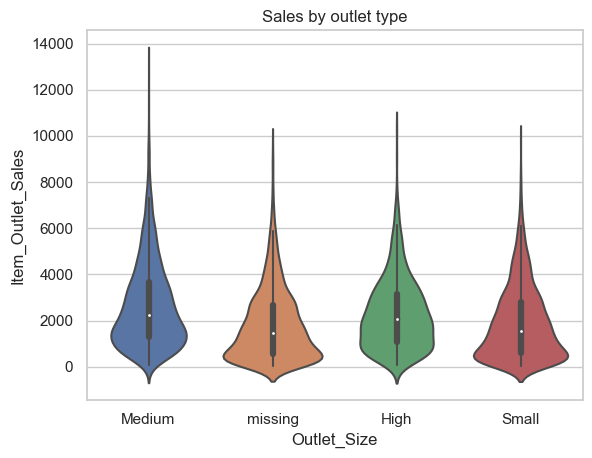

In [55]:
sns.violinplot(x="Outlet_Size", y="Item_Outlet_Sales", data=sales_data_sub,)
plt.title("Sales by outlet type")
plt.show()

We see similar distribution for small and missing so we will impute the missing values with Small

In [45]:
sales_data.Outlet_Location_Type.value_counts(dropna=False)

Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: count, dtype: int64

In [46]:
sales_data.Outlet_Type.value_counts(dropna=False)

Outlet_Type
Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: count, dtype: int64

Analysing relationship between features

In [47]:
pd.crosstab(sales_data.Outlet_Size,sales_data.Outlet_Location_Type)

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
High,0,0,1553
Medium,1550,0,3105
Small,2430,1550,0


In [49]:
pd.crosstab(sales_data.Outlet_Size.isnull(),sales_data.Outlet_Location_Type)

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
False,3980,1550,4658
True,0,3091,925


In [48]:
pd.crosstab(sales_data.Outlet_Size,sales_data.Outlet_Type)

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,1553,0,0
Medium,0,1550,1546,1559
Small,880,3100,0,0
